In [2]:

import pandas as pd
import numpy as np
import pickle
import os
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import numpy as np

import time
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sb
###
import pystan
from scipy.stats import pearsonr, zscore
from MFDFA import fgn
# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sb.set()
from tqdm import tqdm

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')

import stylised_facts.stylised_facts_data_utilities.createLOB as createLOB

%matplotlib inline
import os
os.getcwd()


'/home/ak/Documents/Research/PaperCode'

In [3]:
createLOB.Volestim?

In [4]:
# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs

from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 777



In [5]:
def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)


def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker='o', s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')
    

In [ ]:

# def select_sample_data(ref, sub, price_col, date):
#     '''
#     select a sample of data based on date, assumes datetimeindex
    
#     # args
#         ref: pd.DataFrame containing all ticks
#         sub: subordinated pd.DataFrame of prices
#         price_col: str(), price column
#         date: str(), date to select
#     # returns
#         xdf: ref pd.Series
#         xtdf: subordinated pd.Series
#     '''
#     xdf = ref[price_col].loc[ref[str(date)]
#     xtdf = sub[price_col].loc[date]
#     return xdf, xtdf

In [7]:
folder= '/media/ak/My Passport/Experiment Data/ActivityClockData/'
folderList = os.listdir(folder)
folderList
clocksDataList =[s for s in folderList if ('ClocksData') in s]
correlDataList =[s for s in folderList if ('AtoCor') in s]

In [8]:
idxFile = 1
fileLoc = "".join((folder, clocksDataList[idxFile]))
fileLoc

'/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_FV1_Comdty_20180419_.pkl'

In [9]:
import pickle 
pickle_to_file = pickle.load(open(fileLoc, "rb"))

In [10]:
keys = pickle_to_file.keys()

In [11]:
keys

dict_keys(['OriginalDF', 'TickBarDf', 'VolumeBarDf', 'DollarVolumeBarDf'])


def get_ohlc(ref, sub):
    '''
    fn: get ohlc from custom bars
    
    # args
        ref : reference pandas series with all prices
        sub : custom tick pandas series
    # returns
        tick_df : dataframe with ohlc values
    '''
    ohlc = []
    for i in tqdm(range(sub.index.shape[0]-1)):
        start,end = sub.index[i], sub.index[i+1]
        tmp_ref = ref.loc[start:end]
        max_px, min_px = tmp_ref.max(), tmp_ref.min()
        o,h,l,c = sub.iloc[i], max_px, min_px, sub.iloc[i+1]
        ohlc.append((end,start,o,h,l,c))
    cols = ['End','Start','Open','High','Low','Close']
    return (pd.DataFrame(ohlc,columns=cols))

## uncomment below to run (takes about 5-6 mins on my machine)
#tick_bars_ohlc = get_ohlc(ref, sub)
#cprint(tick_bars_ohlc)

#outfp = PurePath(data_dir/'processed'/'tick_bars_ohlc.parq')
#tick_bars_ohlc.to_parquet(outfp)

In [12]:
column='MicroPrice'
ref=pickle_to_file[list(keys)[0]][str(column)]
sub=pickle_to_file[list(keys)[1]][str(column)]

In [13]:
ohlcDF =createLOB.get_ohlc(ref, sub)

100%|██████████| 77260/77260 [00:19<00:00, 3985.30it/s]


In [ ]:
ohlcDF.head(4)

In [46]:
def get_estimator(price_data, window=30, trading_periods=252, clean=True):
    
    log_ho = (price_data['High'] / price_data['Open']).apply(np.log)
    log_lo = (price_data['Low'] / price_data['Open']).apply(np.log)
    log_co = (price_data['Close'] / price_data['Open']).apply(np.log)
    
    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return trading_periods * v.mean()**0.5
    
    result = rs.rolling(
        window=window,
        center=False
    ).apply(func=f)
    
    if clean:
        return result.dropna()
    else:
        return result

In [47]:
test=get_estimator(ohlcDF)

In [21]:
rogersSatchell=createLOB.Volestim(ohlcDF).rogersSatchell()
hodgesTompkins=createLOB.Volestim(ohlcDF).hodgesTompkins()

In [56]:
hodgesTompkins[-1:]

77259    0.000527
Name: Close, dtype: float64

In [123]:
max_ = []
min_ = []
top_q = []
median = []
bottom_q = []
realized = []
data = []
realized2= []
windows=[10, 30, 60, 90] 
quantiles=[0.25, 0.75]

In [124]:

for window in windows:
    estimator = createLOB.Volestim(ohlcDF, window=window).hodgesTompkins()
    max_.append(estimator.max())
    top_q.append(estimator.quantile(quantiles[1]))
    median.append(estimator.median())
    bottom_q.append(estimator.quantile(quantiles[0]))
    min_.append(estimator.min())
    data.append(estimator)
    realized.append(estimator[-1:])
    realized2.append(estimator.iloc[-1])
   


In [126]:
realized2

[7.307073115249464e-05,
 0.0005273142400922391,
 0.0005954374936406324,
 0.000526397709166843]

In [174]:
yangZhang = createLOB.Volestim(ohlcDF, window=window).yangZhang()


In [183]:
import seaborn as sns
def PlotCones(estiChoice):
    '''
    1: hodges Tompkins
    2: yang Zhang
    3: rogers Satchell
    '''

    max_ = []
    min_ = []
    top_q = []
    median = []
    bottom_q = []
    realized = []
    realized2 = []
    data = []

    windows=[10, 30, 60, 90] 
    quantiles=[0.25, 0.75]
    for window in windows:
        if estiChoice ==1:
            estimator = createLOB.Volestim(ohlcDF, window=window).hodgesTompkins()
        elif estiChoice== 2:
            estimator = createLOB.Volestim(ohlcDF, window=window).yangZhang()
        else:
            estimator = createLOB.Volestim(ohlcDF, window=window).rogersSatchell()
            
        max_.append(estimator.max())
        top_q.append(estimator.quantile(quantiles[1]))
        median.append(estimator.median())
        bottom_q.append(estimator.quantile(quantiles[0]))
        min_.append(estimator.min())
        data.append(estimator)
        realized.append(estimator[-1:])

        
#     size = 15
#     params = {'legend.fontsize': 'large',
#               'figure.figsize': (20, 8),
#               'axes.labelsize': size,
#               'axes.titlesize': size,
#               'xtick.labelsize': size * 0.75,
#               'ytick.labelsize': size * 0.75,
#               'axes.titlepad': 25
    fig = plt.figure(figsize=(16, 9))
    fig.set_facecolor('xkcd:white')
    fig.autofmt_xdate()
    left, width = 0.07, 0.65
    bottom, height = 0.2, 0.7
    left_h = left+width+0.02
    rect_cones = [left, bottom, width, height]
    rect_box = [left_h, bottom, 0.17, height]
    cones = plt.axes(rect_cones)
    box = plt.axes(rect_box)
    realized =  list(np.asarray(pd.DataFrame(realized)).flatten())
    # set the plots
    cones.plot(windows, max_, label="Max")
    cones.plot(windows, top_q, label=str(int(quantiles[1]*100)) + " percentile")
    cones.plot(windows, median, label="Median")
    cones.plot(windows, bottom_q, label=str(int(quantiles[0]*100)) + " percentile")
    cones.plot(windows, min_, label="Min")
    cones.plot(windows, realized, 'r-.', label="Realized")

    # set the x ticks and limits
    cones.set_xticks(windows)
    cones.set_xlim((windows[0]-5, windows[-1]+5))

    # set and format the y-axis labels
    if estiChoice ==1:
        f = lambda x: "%i%%" % round(x*10000, 0)
        
    elif estiChoice ==2:
        f = lambda x: "%i%%" % round(x*10000, 0)
    else:
        f = lambda x: "%i%%" % round(x*1000, 0)
    locs = cones.get_yticks()
    cones.set_yticklabels(map(f, locs))

    # turn on the grid
    cones.grid(True, axis='y', which='major', alpha=0.5)

    # set the title
    #cones.set_title(self._estimator + ' (' + self._symbol + ', daily ' + self._start + ' to ' + self._end + ')')

    # set the legend
    cones.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

    # box plot
    box.boxplot(data, notch=1, sym='+')
    box.plot([i for i in range(1, len(windows)+1)], realized, color='r', marker='*', markeredgecolor='k')

    # set and format the y-axis labels
    locs = box.get_yticks()
    box.set_yticklabels(map(f, locs))

    # move the y-axis ticks on the right side
    box.yaxis.tick_right()

    # turn on the grid
    box.grid(True, axis='y', which='major', alpha=0.5)
    return fig, plt



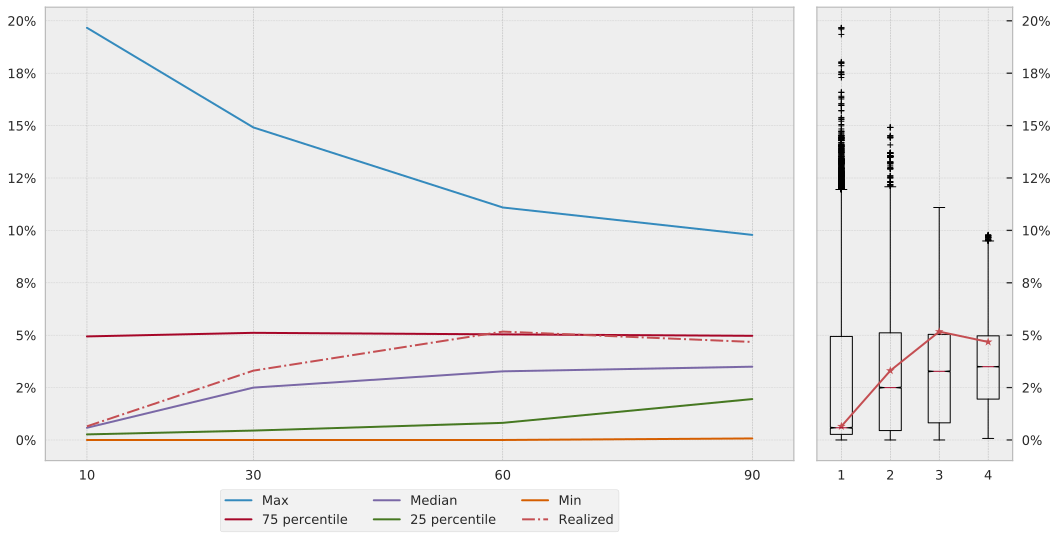

In [186]:
_=PlotCones(estiChoice=4)

(<Figure size 1152x648 with 2 Axes>,
 <module 'matplotlib.pyplot' from '/home/ak/Envs/resrPyth3/lib/python3.6/site-packages/matplotlib/pyplot.py'>)

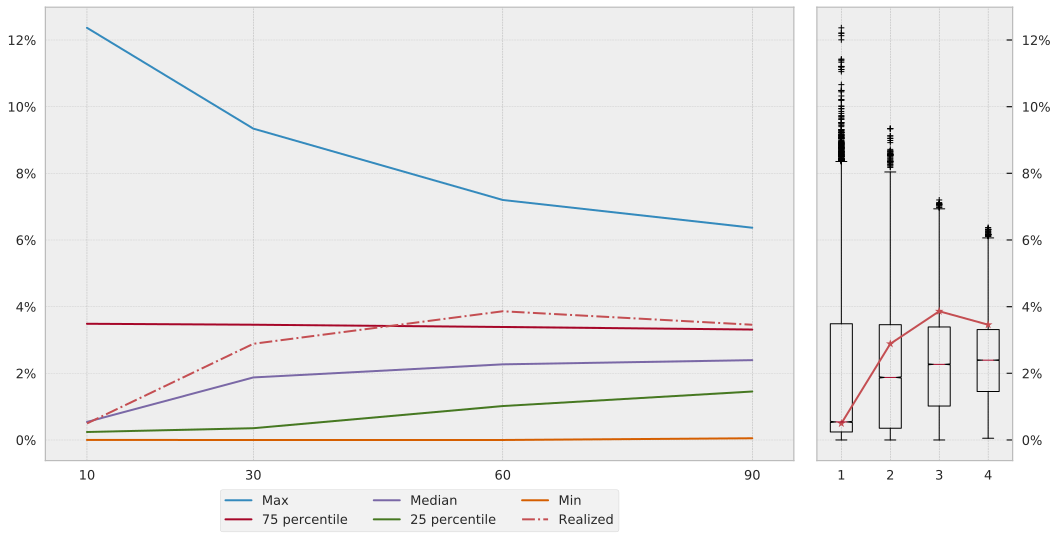

In [187]:
PlotCones(estiChoice=2)

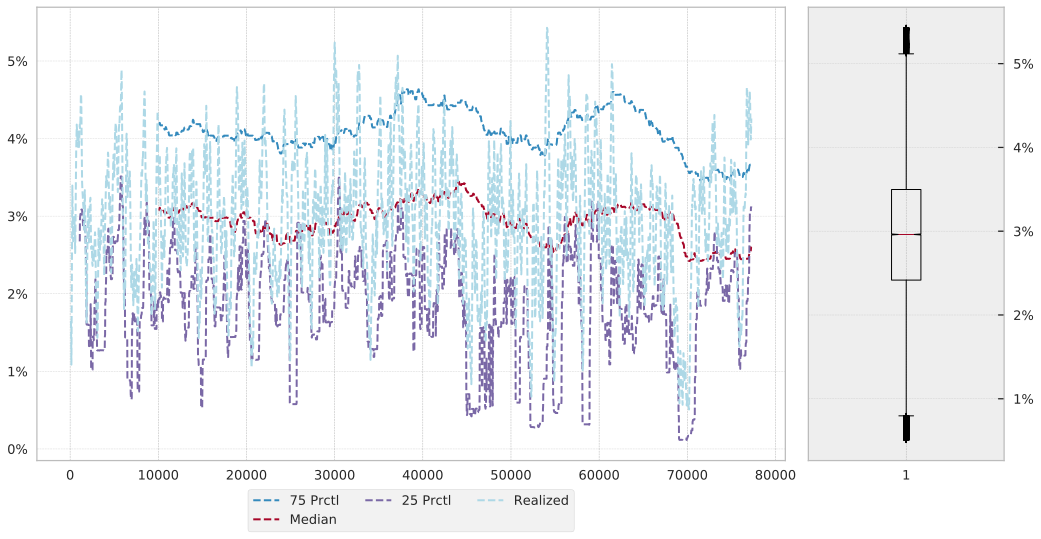

In [227]:
date = estimator.index
window=100
top_q = estimator.rolling(window=10000, center=False).quantile(quantiles[1])
median = estimator.rolling(window=10000, center=False).median()
bottom_q = estimator.rolling(window=1000, center=False).quantile(quantiles[0])
realized = estimator.ewm(com=200).mean()
last = estimator.iloc[-1]
f = lambda x: "%i%%" % round(x*10000, 0)
# figure
size = 15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20, 8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size * 0.75,
          'ytick.labelsize': size * 0.75,
          'axes.titlepad': 25}
fig = plt.figure(figsize=(16, 9))
fig.autofmt_xdate()
left, width = 0.07, 0.65
bottom, height = 0.2, 0.7
left_h = left+width+0.02

rect_cones = [left, bottom, width, height]
rect_box = [left_h, bottom, 0.17, height]

cones = plt.axes(rect_cones)
cones.set_facecolor("white")
box = plt.axes(rect_box)
 # set the plots
cones.plot(date, top_q, linestyle='--', label=str(int(quantiles[1]*100)) + " Prctl")
cones.plot(date, median,linestyle='--', label="Median")
cones.plot(date, bottom_q,linestyle='--', label=str(int(quantiles[0]*100)) + " Prctl")
cones.plot(date, realized,color='lightblue',linestyle= '--', label="Realized")

# set and format the y-axis labels
locs = cones.get_yticks()
cones.set_yticklabels(map(f, locs))

# turn on the grid
cones.grid(True, axis='y', which='major', alpha=0.5)
# set the legend
cones.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# box plots
box.boxplot(realized, notch=1, sym='+')
box.plot(1, last, 'b+')

# set and format the y-axis labels
locs = box.get_yticks()
box.set_yticklabels(map(f, locs))

# move the y-axis ticks on the right side
box.yaxis.tick_right()

# turn on the grid
box.grid(True, axis='y', which='major', alpha=0.5)

In [68]:
# box plot
box.boxplot(data, notch=1, sym='+')
#box.plot([i for i in range(1, len(windows)+1)], realized, color='r', marker='*', markeredgecolor='k')

# set and format the y-axis labels
locs = box.get_yticks()
box.set_yticklabels(map(f, locs))

# move the y-axis ticks on the right side
box.yaxis.tick_right()

# turn on the grid
box.grid(True, axis='y', which='major', alpha=0.5)
plt.show()

In [ ]:

def sim_ema(ticks_adj, tick_window=20):
    # to it in real time as in the simulation...
    sim_ema = pd.Series( index=ticks_adj.index )

    # define our accumulator for the average
    accum = 0
    alpha = 2 / ( tick_window + 1 )
    # loop
    for index, value in ticks_adj.items():
        if pd.isna( value ):
            continue
        if accum == 0:
            accum = value
        else:
            accum = ( alpha * value ) + ( 1 - alpha ) * accum
        sim_ema.loc[ index ] = accum
        return sim_ema
# # sim_ema.plot(color='r')


In [ ]:
df = pickle_to_file[list(keys)[1]]

In [ ]:
ticks_adj =ticks(df)

In [ ]:
size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
# # Calculate autocorrelation for n lags 
# fig, ax1 = plt.subplots(figsize=(8,5))
# for i in np.arange( 1, 1000 ):
#     ax1.bar( i, vticks_adj.autocorr( lag = i ), color = 'red' )
# ax1.set_title( 'Autocorrelation of  volume tick test data by lag' )
# ax1.set_ylabel( 'Autocorrelation' )
# ax1.set_xlabel( 'Lag' )
# plt.show()

In [ ]:
# Calculate autocorrelation for n lags 
def figAutocorrel(ticks_adj,title = 'autocorrelsymbol',xlineLevel=80):
    from matplotlib.ticker import AutoMinorLocator
    size=15
    params = {'legend.fontsize': 'large',
              'figure.figsize': (20,8),
              'axes.labelsize': size,
              'axes.titlesize': size,
              'xtick.labelsize': size*0.75,
              'ytick.labelsize': size*0.75,
              'axes.titlepad': 25}
    fig, ax1 = plt.subplots(figsize=(16,9))
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    #dictionary
    autoCorrelDict ={}

    # Set up the second axis
    ax2 = ax1.twiny()
    ax1.set_facecolor('xkcd:white')
    for i in np.arange( 1, 500 ):
        ax1.bar( i, ticks_adj.autocorr( lag = i ), color = 'blue' )
    ax1.set_title( 'Autocorrelation by lag' )
    ax1.set_ylabel( 'Autocorrelation' )
    ax1.set_xlabel( 'Lag' )
    xtick_labels = [r'$0$', r'$\tau$'] + [r'${}\tau$'.format(k) for k in range(2,ntau)]
    ax2.set_xticklabels(xtick_labels)
    # Initial value of y at t=0, lifetime in s
    N, tau = 1,15
    # Maximum time to consider (s)
    tmax = 500
    # A suitable grid of time points, and the exponential decay itself
    t = np.linspace(0, tmax, 400)
    y = N * np.exp(-t/tau)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    ax1.plot(t, y, color='black', linestyle ='--')
#     axvline(x=.5, ymin=0.25, ymax=0.75)
    ax1.axvline(x=xlineLevel,ymin=0.0, ymax=0.8, ls='--', alpha=0.7, color='#334f8d')
    ax1.text(xlineLevel,0.85,'lag '+str(xlineLevel),rotation=90, fontsize=12)
    plt.savefig('/home/ak/Documents/Research/Papers/figures/'+title+'.png', dpi=150) 
    plt.show()

In [ ]:
figAutocorrel(ticks_adj,title = 'volumeautocorrelsymbol')

In [ ]:
autoCorrelDict ={}
for i in np.arange( 1, 500 ):
        autoCorrelDict[i]=ticks_adj.autocorr( lag = i )

In [ ]:
def autoCorrelDict(ticks_adj):
    autoCorrelDict ={}
    for i in np.arange( 1, 500 ):
        autoCorrelDict[i]=ticks_adj.autocorr( lag = i )
    return autoCorrelDict
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initial value of y at t=0, lifetime in s
N, tau = 1, 50
# Maximum time to consider (s)
tmax = 1000
# A suitable grid of time points, and the exponential decay itself
t = np.linspace(0, tmax, 1000)
y = N * np.exp(-t/tau)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, y)

# The number of lifetimes that fall within the plotted time interval
ntau = tmax // tau + 1
# xticks at 0, tau, 2*tau, ..., ntau*tau; yticks at the corresponding y-values
xticks = [i*tau for i in range(ntau)]
yticks = [N * np.exp(-i) for i in range(ntau)]
ax.set_xticks(xticks)
ax.set_yticks(yticks)

# xtick labels: 0, tau, 2tau, ...
xtick_labels = [r'$0$', r'$\tau$'] + [r'${}\tau$'.format(k) for k in range(2,ntau)]

# corresponding ytick labels: N, N/e, N/2e, ...
ytick_labels = [r'$N$',r'$N/e$'] + [r'$N/{}e$'.format(k) for k in range(2,ntau)]
ax.set_yticklabels(ytick_labels)
plt.tick_params(axis='both',which = 'major', labelsize=8, width=2)
plt.tick_params(axis='both',which = 'minor', labelsize=8, width=1)

ax.set_xlabel(r'$t\;/\mathrm{s}$')
ax.set_ylabel(r'$y$')
ax.grid()
plt.show()

In [ ]:
string='FB1_Comdty-20180417.csv'
"_".join((string.split('-')[0],string.split('-')[1].split('.')[0],'.pkl'))

In [ ]:
from stylised_facts.stylised_facts_data_utilities import mdfda

In [ ]:
os.getcwd()
''' Locations'''
cwd= os.getcwd()
extHD = '/media/ak/My Passport/'
extHdData = "".join((extHD, 'Data'))
extHdExpData = "".join((extHD, 'Experiment Data')) #['features', 'labels', 'metrics', 'models']
extHdFutures = "".join((extHD, 'Barket Data/raw bloomberg data')) #futures
bmrg_folders=[s for s in os.listdir(extHdFutures) if ('Comdty') in s]

In [ ]:
os.listdir(extHdExpData)
cleanLOBFolder = "/".join((extHdExpData,'CleanLOBData'))
symbols =sorted(os.listdir(cleanLOBFolder))

In [ ]:
symbolIdx = 0
symbolCleanSymbolFolder = "/".join((cleanLOBFolder, symbols[symbolIdx]))
symbolCleanFilesList = os.listdir(symbolCleanSymbolFolder)

In [ ]:
dfTest =pd.read_csv("/".join((symbolCleanSymbolFolder,symbolCleanFilesList[0])))

In [ ]:
dfTest.columns.values

In [ ]:
dfTestCopy = dfTest.copy(deep=True)

In [ ]:
dfGrouped = dfTestCopy.groupby('TradeTime')['BidSize', 'AskSize', 'TradeSize']
dfGroupedSum = dfGrouped.sum()
#this needs to be a function I think

In [ ]:
dfMergedtEST =dfTestCopy.merge(dfGroupedSum, on='TradeTime')

In [ ]:
dfTestCase = dfMergedtEST.drop(columns=['Unnamed: 0','type_x','type_y','AskQuoteId','BidQuoteId'])

In [ ]:
os.listdir(extHdFutures)
bmrg_folders=[s for s in os.listdir(extHdFutures) if ('Comdty') in s]
# bmrg_trades=sorted([s for s in os.listdir(dataOnlyDrive) if s.endswith('y_trades')])
# bmrg_quotes=sorted([s for s in os.listdir(dataOnlyDrive) if s.endswith('y_quotes')])
# bmrg_tickers=sorted([bmrg_trades[idx].split('_t')[0] for idx,_ in enumerate(bmrg_trades)])

In [ ]:
test=createLOB.rawLOBFIle(futuresFolder=extHdFutures, symbolsFolder=bmrg_folders, symbolID=1,fileID=15)
# test.shape
# testLOB= dfTestCopy
test.head(5)

In [ ]:
LOB =createLOB.createLOB(test)
LOB.head(4)

In [ ]:
dfraw = createLOB.calcLOB(createLOB.formatLOB(LOB))
dfraw.columns.values

In [ ]:
dfraw.tail(4)

In [ ]:
activityClocks = createLOB.Clocks(dfraw, 'MicroPrice', 'TradeVolume','DollarVolume',1,5,5)

In [ ]:
def volume_bars(df, volume_column, m):
    '''
    compute volume bars

    # args
        df: pd.DataFrame()
        volume_column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx].drop_duplicates()

In [ ]:
volume_M =1 
print(f'volume threshold: {volume_M:,}')
v_bar_df = volume_bar_df(dfraw, 'TradeVolume', volume_M)

In [ ]:
dfVolDf= createLOB.calcLOB(activityClocks.volume_bar_df())
dfTickDf= createLOB.calcLOB(activityClocks.tick_bar_df())
dfDVDF = createLOB.calcLOB(activityClocks.dollar_bar_df())

In [ ]:
dict={}
dict['VolumeClockDf']=activityClocks.volume_bar_df()
dict['TickClockDf']=activityClocks.tick_bar_df()
dict['DollarVolumeClockDf']=activityClocks.tick_bar_df()



In [ ]:
dict.keys()

In [ ]:
dfCreatedLOB['DollarVolumeTraded'] = np.array(df.TradePrice)*np.array(df.TradeVolume)


In [ ]:
dfTickDf.MicroPrice.pct_change()

In [ ]:
drvolume = createLOB.calcLOB(createLOB.formatLOB(clocks.volume_bar_df()))

In [ ]:
drvolume.columns.values

In [ ]:
tickdf = createLOB.calcLOB(createLOB.formatLOB(df))

In [ ]:
plt.plot(tickdf.MicroPricePctChange.dropna())

In [ ]:
# symbolID=1
# futuresFolder= extHdFutures
# symbolsFolder=bmrg_folders
# listDatesFiles = os.listdir("/".join((futuresFolder, symbolsFolder[symbolID])))
# symbol=symbolsFolder[symbolID].split("_")[0]

In [ ]:
# for symbolIDX, _ in enumerate(symbolsFolder):
#     noFiles = len(os.listdir())
#     print(symbolsFolder[symbolIDX], symbolIDX)
    

In [ ]:

# testLOB =(createLOB.createLOB(rawLOBFile = test))
# cleanLOB =createLOB.formatLOB(testLOB)
# cleanLOBDate = str(pd.to_datetime(cleanLOB.QuoteTime[0]).date())

In [ ]:
from stylised_facts.stylised_facts_data_utilities import createLOB as createLOB


In [ ]:

mad = activityClocks.mad_outlier(df)

In [ ]:
df[~mad]

In [ ]:
# cleanLOBDateFileName = "_".join(('LOB',str(symbol),cleanLOBDate+".csv"))

In [ ]:
# cleanLOBDateFileName
# cleanLOBFileLoc = "/".join((cleanLOBFolder,symbol ,cleanLOBDateFileName))

In [ ]:
# cleanLOB.to_csv(cleanLOBFileLoc)

In [ ]:
# cleanLOB.columns.values

In [ ]:
# cleanLOB['TimeStamp']=pd.to_datetime(cleanLOB.TradeTime).dt.time
# cleanLOB['milliSeconds'] = [(((x.hour * 60 + x.minute) * 60 + x.second) * 1000) for x in cleanLOB['TimeStamp']]

In [ ]:
# listDatesFiles = ("/".join((futuresFolder, symbolsFolder[symbolID])))
# rawLOBFile = pd.read_csv("/".join((futuresFolder, symbolsFolder[symbolID], listDatesFiles[symbolID])))

In [ ]:
dfLOB =testLOB.loc[~mad]

In [ ]:
dfLOB.columns.values

In [ ]:
# dfLOB['TradedDollarVolume'] =dfLOB.TradeSize*dfLOB.TradePrice
# cleanLOB['TradedDollarVolume'] =cleanLOB.TradeSize*dfLOB.TradePrice

## Volume Bars ##

In [ ]:
n_ticks = testLOB.shape[0]
volume_ratio = (testLOB.TradeSize.sum()/n_ticks).round()
dollar_ratio = (testLOB.DollarVolumeTraded.sum()/n_ticks).round()
print(f'num ticks: {n_ticks:,}')
print(f'volume ratio: {volume_ratio}')
print(f'dollar ratio: {dollar_ratio}')

In [ ]:
from MFDFA import MFDFA

In [ ]:
t_final= np.array(np.max(clocks.tick_bar_df().shape[0], clocks.volume_bar_df().shape[0], clocks.dollar_bar_df().shape[0]))
delta_t=1 #tick

In [ ]:
# The time array of the trajectory
time = np.arange(0, t_final, delta_t)
# y = np.asarray(clocks.tick_bar_df().MicroPricePctChange)

In [ ]:
#This is the stochastic trajectory over time
plt.plot( y_tick, label = r'Trajectory of MicroPrice Pct Change')
plt.plot(y_dv, color='r')

plt.xlabel(r'time $t$')
plt.ylabel(r'$y(t)$')
plt.legend()

In [ ]:
# Select a band of lags, which usually ranges from 
# very small segments of data, to very long ones, as
lag = np.logspace(0.7, 4, 60).astype(int)
# Notice these must be ints, since these will segment
# the data into chucks of lag size

# Select the power q
q = 9

# The order of the polynomial fitting
order = 2

# Obtain the (MF)DFA as
lag, dfa = MFDFA(y, lag = lag, q = q, order = order)

In [ ]:
plt.plot(lag, dfa)

In [ ]:
# To uncover the Hurst index, lets get some log-log plots
plt.loglog(lag, dfa, 'o', label='fOU: MFDFA q=2')

# And now we need to fit the line to find the slope. We will
# fit the first points, since the results are more accurate 
# there. Don't forget that if you are seeing in log-log
# scales, you need to fit the logs of the results
np.polyfit(np.log(lag[:15]), np.log(dfa[:15]),1)[0]
plt.show()
# Now what you should obtain is: slope = H + 1

In [ ]:
# Lets take three examples, with H=0.3, H=0.5, H=0.7
# The total integration time, as before
t_final = 500

# The desired timestep of integration
delta_t = 0.001

# time array of the process
time = np.linspace(0, t_final, t_final * int(1 / delta_t))

# Generate three fractional Gaussian noises dB 
H_anti = 0.3       # Anti-presistent noise
H_regu = 0.5       # Regular noise
H_posi = 0.7       # Positively correlated noise

# Generate the noises (with the appropriate normalisation)
dB_anti = (t_final ** H_anti) * fgn(N = time.size, H = H_anti)
dB_regu = (t_final ** H_regu) * fgn(N = time.size, H = H_regu)
dB_posi = (t_final ** H_posi) * fgn(N = time.size, H = H_posi)

In [ ]:
# # Let's plot the noises, and the associated motions

# fig, ax = plt.subplots(2,3, figsize=(12,4));

# ax[0,0].plot(time, dB_anti)
# ax[0,1].plot(time, dB_regu)
# ax[0,2].plot(time, dB_posi)

# # their motions are given by the integral of the noise,
# # i.e., the cumsum of the processew 

# ax[1,0].plot(time, np.cumsum(dB_anti))
# ax[1,1].plot(time, np.cumsum(dB_regu))
# ax[1,2].plot(time, np.cumsum(dB_posi))

In [ ]:
import os
def require(fname):
    if not os.path.exists(fname):
        from urllib import urlretrieve
        print ('Downloading %s.')%fname
        urlretrieve('http://bsp.brain.riken.jp/~juricap/mdfa/%s'%fname,fname)
    if fname.endswith('.zip'):
        import zipfile
        try:
            zipfile.ZipFile(fname).extractall()
        except Exception as exc:
            print( exc)


plt.rcParams['figure.figsize'] = (14,8)
from scipy.io import loadmat
from numpy import cumsum, polyfit, polyval, mean, sqrt
import matplotlib.pyplot as plt 
SAVE = False

In [ ]:
RW1=np.cumsum(y-np.mean(y));
A = 10.0

In [ ]:
np.ma.array?

In [ ]:
plt.plot(A*y)
plt.plot(RW1,'r',lw=1.5)

In [ ]:
from numpy import cumsum
def plot_trends(X,scale,m=1,label='',title=''):
    t = np.arange(X.shape[0])
    plt.plot(t,X,lw=2.0)
    for i0 in range(0,X.shape[0]-scale+1,scale):
        i1 = i0+scale
        t0 = t[i0:i1]
        C = polyfit(t0,X[i0:i1],m)
        fit = polyval(C,t0);
        RMS = np.sqrt(((X[i0:i1]-fit)**2).mean())
        plt.plot(t0,fit,color='r',linestyle='--')
        plt.plot(t0,fit-RMS,'r')
        plt.plot(t0,fit+RMS,'r')
    plt.ylabel(label,ha='center')
#     if title: plt.text(100,500,title,fontsize=12) 

scale = 1000
RW = cumsum(y-y.mean())

plt.subplot(311)
plt.title('A Linear detrending')
plot_trends(RW1,scale,1,label='Multifractal signal\namplitude',
            title='A Linear detrending')
plt.legend(['Noise like time-series','Local trend','+/- 1 local RMS'], prop={'size': 6}, loc='upper right')
plt.subplot(312)
plt.title('B Quadratic detrending')
plot_trends(RW1,scale,2,label='MicroPrice Change\namplitude',
            title='B Quadratic detrending')
plt.subplot(313)
plt.title('C Cubig detrending')
plot_trends(RW1,scale,3,label='MicroPrice Change\namplitude',
            title='C Cubic detrending')

In [ ]:
plot_trends(RW1,scale,1,label='Multifractal signal\namplitude',
            title='A Linear detrending')

In [ ]:
def trends(X,scale,m=1):
    t = np.arange(X.shape[0])
    segments = np.arange(0,X.shape[0]-scale+1,scale)
    RMS = []
    for i0 in segments:
        i1 = i0+scale
        t0 = t[i0:i1]
        C = polyfit(t0,X[i0:i1],m)
        fit = polyval(C,t0)
        RMS.append( sqrt(((X[i0:i1]-fit)**2).mean()) )
    return np.array(RMS)

RW = cumsum(y-y.mean())
scales = 2**np.arange(4,11)
#[16,32,64,128,256,512,1024];
m = 1



In [ ]:
import time

In [ ]:
from stylised_facts.stylised_facts_data_utilities import mdfda as mdfda

In [ ]:
X =np.arange(9000)
# mdfda.rw(X,4,3)
type(y)

In [ ]:
scstep = 8
t0 = time.clock()
scales = np.floor(2.0**np.arange(4,10.1,1.0/scstep)).astype('i4')
RW = mdfda.rwalk(y.ravel())

RMS = mdfda.compRMS(RW,scales,1)
dtslow = time.clock() - t0
print ('Took %0.3fs'%dtslow)

In [ ]:
# qstep = 4
# qs = np.arange(-5,5.01,1.0/qstep)
# Fq = mdfda.compFq(RMS,qs)

# plt.subplot(121)
# plt.plot(scales[::scstep//2],Fq[::scstep//2,::qstep],'.-',lw=0.1)
# plt.gca().set_xscale('log')
# gca().set_yscale('log')
# Hq = zeros(len(qs),'f8')
# for qi,q in enumerate(qs):
#     C = polyfit(log2(scales),log2(Fq[:,qi]),1)
#     Hq[qi] = C[0]
#     if abs(q - int(q)) > 0.1: continue
#     loglog(scales,2**polyval(C,log2(scales)),lw=0.5,label='q=%d [H=%0.2f]'%(q,Hq[qi]))
# margins(0,0)
# legend(loc='lower right')
# plt.xticks(scales[::scstep],scales[::scstep]);
# plt.yticks([0.1,1.0,10.0],[0.1,1.0,10.0])
# plt.xlabel('scale')
# plt.ylabel('Fq')

# plt.subplot(122)
# tq = Hq*qs - 1
# hq = diff(tq)/(qs[1]-qs[0])
# Dq = (qs[:-1]*hq) - tq[:-1]
# plot(hq,Dq,'.-')
# xlabel('hq'); ylabel('Dq')

### Volume Clock ###

In [ ]:
def volume_bars(df, volume_column, m):
    '''
    compute volume bars

    # args
        df: pd.DataFrame()
        volume_column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx].drop_duplicates()

In [ ]:
dfLOB.columns.values

In [ ]:
volume_M =5 

In [ ]:
print(f'volume threshold: {volume_M:,}')
v_bar_df = volume_bar_df(dfLOB, 'TradeSize', volume_M)


In [ ]:
v_bar_df.shape

In [ ]:
clocks.volume_bar_df().shape

In [ ]:
import cprint
from cprint import *

In [ ]:
dfLOB.MicroPrice.loc[3]

In [ ]:
dfLOB.columns.values

In [ ]:
dfLOB.TradedTime.values

In [ ]:
x= dfLOB.MicroPricePctChange.values

In [ ]:
import powerlaw

In [ ]:
fit =powerlaw.Fit(x)

In [ ]:
print(fit.alpha)
print(fit.sigma)

In [ ]:
data= x
fit = powerlaw.Fit(data, discrete=True, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = powerlaw.Fit(data, discrete=True, xmax=1000)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")


In [ ]:
# fit = powerlaw.Fit(data, discrete=True)
# ####
# fit.distribution_compare('power_law', 'lognormal')
# fig = fit.plot_ccdf(linewidth=3, label='Empirical Data')
# fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
# fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
# ####
# fig.set_ylabel(u"p(X≥x)")
# fig.set_xlabel("Frequency")
# handles, labels = fig.get_legend_handles_labels()
# fig.legend(handles, labels, loc=3)

In [ ]:
absMPchange = np.abs(v_bar_df.MicroPricePctChange).dropna()

In [ ]:
x=(np.abs(v_bar_df.MicroPricePctChange)/v_bar_df.Duration).dropna()

In [ ]:
v_bar_df

In [ ]:
x[~np.isfinite(x)] = 0

In [ ]:
x = 1000000*x

In [ ]:
x2=x.drop(x.idxmax())

In [ ]:
activity =x[x<1]
activity.describe()

In [ ]:
#This is the stochastic trajectory over time
plt.plot(x, label = r'MicroPrice Pct Change/Duration')

plt.xlabel(r'time $t$')
plt.ylabel(r'$y(t)$')
plt.legend()

In [ ]:
activity.hist(bins=50, label='activity')

In [ ]:
ticks = np.sign(dfLOB.TradePrice -dfLOB.TradePrice.shift(1) )
ticks_adj = ticks.copy()

In [ ]:
def ticks(df):
    ticks = np.sign(df.TradePrice -df.TradePrice.shift(1) )
    ticks_adj = ticks.copy().replace(to_replace=0, method='ffill')
    return tick_adj
def ema(ticks_adj, tick_window =20):
    '''
    returns exponential moving average of ticks, for a predefined window
    '''
    ema = ticks_adj.ewm( span=tick_window ).mean()
    return ema

In [ ]:
ticks_adj = ticks.replace(to_replace=0, method='ffill')

In [ ]:
ticks_adj.tail(20)

In [ ]:
# Calculate autocorrelation for n lags 
fig, ax1 = plt.subplots(figsize=(16,9))
for i in np.arange( 1, 1000 ):
    ax1.bar( i, ticks_adj.autocorr( lag = i ), color = 'blue' )
ax1.set_title( 'Autocorrelation of tick test data by lag' )
ax1.set_ylabel( 'Autocorrelation' )
ax1.set_xlabel( 'Lag' )
plt.show()

In [ ]:
# Calculate our signal: collect trades - we'll use tick count

# determine our window size
tick_window = 20

# Calc EMA directly (alpha = 2 / span +1)
ema = ticks_adj.ewm( span=tick_window ).mean()


In [ ]:
ema.plot()

In [ ]:
from numpy import r_
def trends(X,scale,m=1):
    t = np.arange(X.shape[0])
    segments = np.arange(0,X.shape[0]-scale+1,scale)
    RMS = []
    for i0 in segments:
        i1 = i0+scale
        t0 = t[i0:i1]
        C = polyfit(t0,X[i0:i1],m)
        fit = polyval(C,t0)
        RMS.append( sqrt(((X[i0:i1]-fit)**2).mean()) )
    return np.array(RMS)

RW = cumsum(ema-ema.mean())
scales = 2**np.arange(4,11)
#[16,32,64,128,256,512,1024];
m = 1

plt.figure(figsize=(14,10))
RMS = {}
for si, scale in enumerate(scales):
    plt.subplot(len(scales),1,len(scales)-si)
    t = np.arange(0,RW.shape[0]+1,scale)
    RMS[scale] = trends(RW,scale,m)
    plt.step(t,r_[RMS[scale],RMS[scale][-1]],where='post')
    plt.plot(xlim(),r_[1,1]*RMS[scale].mean(),'r',lw=2.0)
    plt.text(8100,RMS[scale].mean(),'Scale = %d'%scale)
    if scale < 128:
        yticks([0,5,10,20])
    else:
        yticks([0,10,20,40])

plt.xlabel('Sample index')
plt.subplot(len(scales),1,len(scales)//2+1)
plt.ylabel('Amplitude')

In [ ]:
def sim_ema(ticks_adj):
    # to it in real time as in the simulation...
    sim_ema = pd.Series( index=ticks_adj.index )

    # define our accumulator for the average
    accum = 0
    alpha = 2 / ( tick_window + 1 )
    # loop
    for index, value in ticks_adj.items():
        if pd.isna( value ):
            continue
        if accum == 0:
            accum = value
        else:
            accum = ( alpha * value ) + ( 1 - alpha ) * accum
        sim_ema.loc[ index ] = accum
        return sim_ema

In [ ]:
sim_ema.plot(color='r')
plt.show()

In [ ]:
values = pd.concat([sim_ema, ema], axis=1)
values.columns = ['sim_ema', 'ema']

In [ ]:

(values.sim_ema - values.ema).head(200).plot()

In [ ]:
RW1=np.cumsum(ema-np.mean(ema));
A = 10.0
t_final= len(ema)
delta_t=1 #tick
# The time array of the trajectory
time = np.arange(0, t_final, delta_t)


In [ ]:
y=ema
scale = 1000
RW = cumsum(y-y.mean())
plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.title('A Linear detrending')
plot_trends(RW1,scale,1,label='Multifractal signal\namplitude',
            title='A Linear detrending')
plt.legend(['Noise like time-series','Local trend','+/- 1 local RMS'], prop={'size': 6}, loc='upper right')
plt.subplot(312)
plt.title('B Quadratic detrending')
plot_trends(RW1,scale,2,label='MicroPrice Change\namplitude',
            title='B Quadratic detrending')
plt.subplot(313)
plt.title('C Cubic detrending')
plot_trends(RW1,scale,3,label='MicroPrice Change\namplitude',
            title='C Cubic detrending')
plt.subplots_adjust(hspace=0.5)